In [259]:
import numpy as np
import pandas as pd
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import pickle
import json

%matplotlib inline

In [260]:
def return_track(agg, objective, type_track='true'):
    
    tracks = []
    
    if type_track=='true':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                argmins = agg[i, j, 1][agg[i, j, 4]]
                values = objective(argmins)
                subtracks.append(values)
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)
        
    elif type_track=='noisy':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                subtracks.append(np.minimum.accumulate(agg[i, j, 2] / agg[i, j, 3]).ravel())
            tracks.append(np.array(subtracks))
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)

In [334]:
key = 'sqmichalewicz5_2_2_50_100_ind1'
f_name, bound, dims, low_fid, high_fid, index = key.split('_')
bound = float(bound)
dims = int(dims)
low_fid = int(low_fid)
high_fid = int(high_fid)

In [335]:
with open('new_funs/'+key+'.txt', 'rb') as f:
    agg = json.load(f)

In [336]:
agg = np.array(agg)
for i in range(len(agg)):
    for j in range(len(agg[i])):
        for k in range(len(agg[i,j])):
            agg[i,j,k] = np.array(agg[i,j,k])

In [337]:
from functionDoESpecial import functionDoESpecial, function_dimensions, function_names
from binomial_optimization2 import optimization_step, value_generator

objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: ((functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v))

[ 0.025]


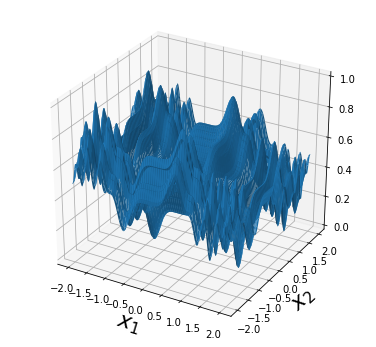

In [338]:
xs = np.linspace(-bound, bound, 300)
ys = np.linspace(-bound, bound, 300)
xs, ys = np.meshgrid(xs, ys)
values = objective(np.dstack([xs, ys]).reshape(90000, 2)).reshape(300, 300)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)
ax.set_xlabel(r"$x_1$", fontsize=22)
ax.set_ylabel(r"$x_2$", fontsize=22)
print(objective(argmin.reshape(1, -1)))

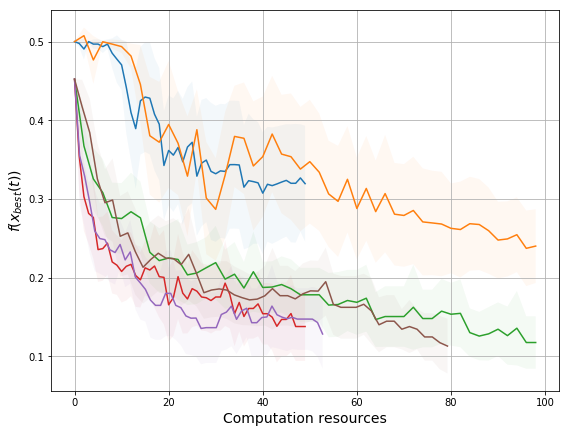

In [339]:
means, stds = return_track(agg, objective)
stds /= 2.

plt.figure(figsize=(20, 7))
# plt.suptitle(f_name, fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
# plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f='+str(low_fid))
# plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.05)
# plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f='+str(high_fid))
# plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.05)
# plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f='+str(high_fid))
# plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.05)
# plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f='+str(low_fid))
# plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.05)
# plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, decision function 1')
# plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.05)
# plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, decision function 2')
# plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.05)
# plt.xlabel('Iteration', fontsize=14)
# plt.ylabel(r'$f(x_{best}(t))$', fontsize=14)
# plt.legend()
# plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f='+str(low_fid))
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.05)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f='+str(high_fid))
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.05)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f='+str(high_fid))
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.05)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f='+str(low_fid))
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.05)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, decision function 1')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.05)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, decision function 2')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.05)
plt.xlabel('Computation resources', fontsize=14)
plt.ylabel(r'$f(x_{best}(t))$', fontsize=14)
plt.grid()
# plt.legend(fontsize=14)
# plt.yscale('log', nonposy='clip')

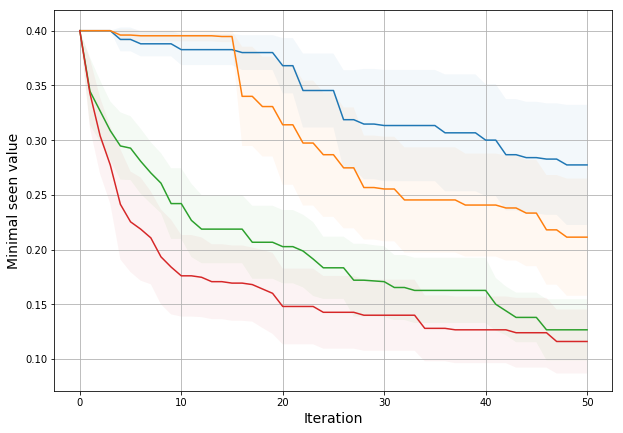

In [340]:
means, stds = return_track(agg, objective, type_track='noisy')
stds /= 2.
cut=6
means = means[:, cut:]
stds = stds[:, cut:]

plt.figure(figsize=(10, 7))
# plt.suptitle(f_name, fontsize=20)
# plt.subplot(1,2,1)
plt.plot(np.arange(len(means[0])),  np.repeat(means[0], 2)[:len(means[0])], label='Gaussian, f='+str(low_fid))
plt.fill_between(np.arange(len(means[0])), np.repeat(means[0]+stds[0], 2)[:len(means[0])],  np.repeat(means[0]-stds[0], 2)[:len(means[0])], alpha=0.05)
plt.plot(np.arange(len(means[1])),  np.repeat(means[1], 2)[:len(means[1])], label='Gaussian, f='+str(high_fid))
plt.fill_between(np.arange(len(means[1])), np.repeat(means[1]+stds[1], 2)[:len(means[1])],  np.repeat(means[1]-stds[1], 2)[:len(means[1])], alpha=0.05)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f='+str(high_fid))
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.05)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f='+str(low_fid))
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.05)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Minimal seen value', fontsize=14)
plt.grid()
# plt.legend(fontsize=14)
# plt.yscale('log', nonposy='clip')
# plt.subplot(1,2,2)
# max_f = np.max(agg[1, 0, 3])
# min_f = np.min(agg[0, 0, 3])
# plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f='+str(low_fid))
# plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.05)
# plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f='+str(high_fid))
# plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.05)
# plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f='+str(high_fid))
# plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.05)
# plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f='+str(low_fid))
# plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.05)
# plt.xlabel('Computation resources', fontsize=14)
# plt.legend(fontsize=14)
# plt.title("Best point value per iteration")
# plt.yscale('log', nonposy='clip')

In [313]:
max_fidelity = high_fid
min_fidelity = low_fid
mean_fidelities = []
for i in range(agg.shape[0]):
    mean_fidelities.append(agg[i, :, 3].mean().mean())

In [314]:
for i in range(agg.shape[0]):
    idx = int((len(means[i])-1)/mean_fidelities[i]*min_fidelity)
    print(i, means[i][idx], stds[i][idx])

0 0.0757907881092 0.00834317294649
1 0.0817025342742 0.0093255481921
2 0.0704109057722 0.00740321773112
3 0.0737046331872 0.0101145960209
4 0.0651176592895 0.00793880542223
5 0.0706088703034 0.00701295982913


In [ ]:
means